## The similarity scores from different MSAs are highly correlated

In [2]:
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/MsaPhylo/')

Mounted at /content/drive


In [7]:
from matplotlib import font_manager as fm
!mkdir -p ~/.fonts
!cp arial.ttf ~/.fonts/
!fc-cache -fv

font_dir = os.path.join(os.environ['HOME'], '.fonts')
os.makedirs(font_dir, exist_ok=True)
font_name = 'arial.ttf'
font_path = os.path.join(font_dir, font_name)
fm.fontManager.addfont(font_path)

!cp {font_name} {font_dir}

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


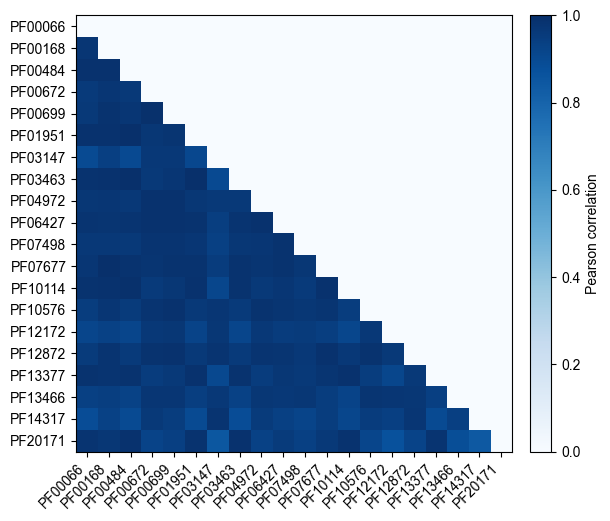

In [8]:
def correlated_simi(protein_domain, metrics):

    """Loads attention score data for default, shuffled column, and shuffled covariance MSAs from a specified base path."""

    base_path = 'score'
    default_file_name = 'attn_score.csv'
    default_file_path = os.path.join(base_path, default_file_name)

    if not os.path.exists(default_file_path):
        raise FileNotFoundError(f"{default_file_path} doesn't exist!")

    # Load default MSA data
    attn_data = pd.read_csv(default_file_path)
    attn_data['ProteinDomain'] = attn_data['FileName'].str.extract(r'(PF\d+)_')
    attn_data['Layers'] = attn_data['FileName'].str.extract('default_(\d+)_')[0].astype(int)
    attn_data['Heads'] = attn_data['FileName'].str.extract('default_\d+_(\d+)')[0].astype(int)
    attn_data = attn_data.sort_values(by=['ProteinDomain', 'Layers', 'Heads']).drop(['FileName'], axis=1)
    attn_data = attn_data.reindex(columns=['ProteinDomain', 'Layers', 'Heads',
                                           'NJRFScore', 'MLRFScore', 'NJCI', 'MLCI'])
    attn_data = attn_data[attn_data['ProteinDomain'] == protein_domain]
    val = attn_data[metrics].to_numpy()

    return val

def cal_pearsons(metrics):

  pearsons_coeffs = []
  for i, pfam_family_x in enumerate(protein_domain_list):
    for pfam_family_y in protein_domain_list[i + 1:]:
        x = correlated_simi(pfam_family_x, metrics).flatten()
        y = correlated_simi(pfam_family_y, metrics).flatten()

        pearsons_coeffs.append(pearsonr(x, y)[0])

  pearsons_coeffs = squareform(np.array(pearsons_coeffs))

  return pearsons_coeffs


with open('./data/Pfam/protein_domain.txt', 'r') as file:
  lines = file.readlines()
protein_domain_list = [line.strip() for line in lines]
pearsons_coeffs2 = cal_pearsons('NJRFScore')

labels = [pfam_family for i, pfam_family in enumerate(protein_domain_list)]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['arial']
fig, ax = plt.subplots(figsize=(6, 6),
                       constrained_layout=True)
im = ax.imshow(np.tril(pearsons_coeffs2),
               cmap='Blues',
               aspect="equal",
               vmin=0, vmax=1)
ax.set_yticks(np.arange(len(protein_domain_list)),
              labels=labels)
ax.set_xticks(np.arange(len(protein_domain_list)),
              labels=labels,
              rotation=45,
              ha="right")
fig.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label="Pearson correlation")

plt.show()